<a href="https://colab.research.google.com/github/KacperKuznik/cats-dogs-classification/blob/main/Cats_vs_Dogs_CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteINHWCM/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
batch_size = 32
img_height = 100
img_width = 100

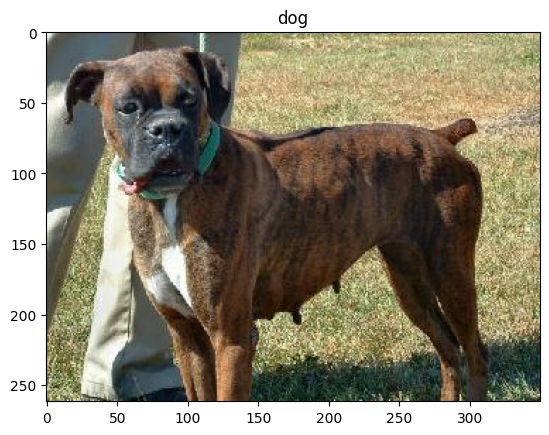

In [4]:
import matplotlib.pyplot as plt

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [5]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(img_height, img_width),
  tf.keras.layers.Rescaling(1./255)
])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_ds(ds, shuffle=False):
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
            num_parallel_calls=AUTOTUNE)
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [7]:
train_ds = prepare_ds(train_ds, shuffle=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

In [8]:
model = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[stop_early]
)

Epoch 1/20
582/582 [==============================] - 200s 335ms/step - loss: 0.6484 - binary_accuracy: 0.6087 - val_loss: 0.6289 - val_binary_accuracy: 0.6574
Epoch 2/20
582/582 [==============================] - 166s 285ms/step - loss: 0.5591 - binary_accuracy: 0.7083 - val_loss: 0.5153 - val_binary_accuracy: 0.7485
Epoch 3/20
582/582 [==============================] - 167s 288ms/step - loss: 0.5220 - binary_accuracy: 0.7367 - val_loss: 0.4896 - val_binary_accuracy: 0.7558
Epoch 4/20
582/582 [==============================] - 168s 288ms/step - loss: 0.4929 - binary_accuracy: 0.7609 - val_loss: 0.4590 - val_binary_accuracy: 0.7936
Epoch 5/20
582/582 [==============================] - 163s 280ms/step - loss: 0.4700 - binary_accuracy: 0.7753 - val_loss: 0.4330 - val_binary_accuracy: 0.7984
Epoch 6/20
582/582 [==============================] - 164s 281ms/step - loss: 0.4530 - binary_accuracy: 0.7872 - val_loss: 0.4132 - val_binary_accuracy: 0.8065
Epoch 7/20
582/582 [====================

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 100, 100, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)       

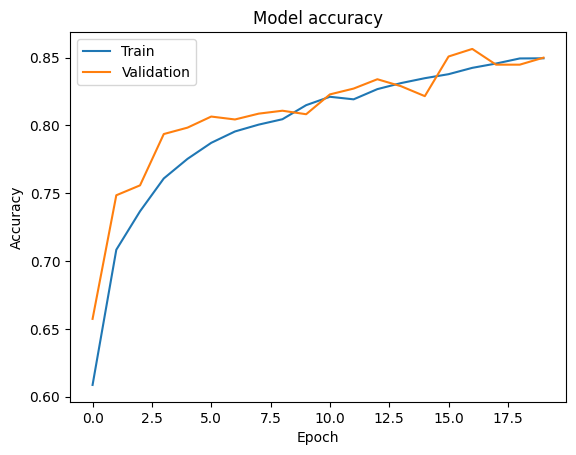

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 224ms/step


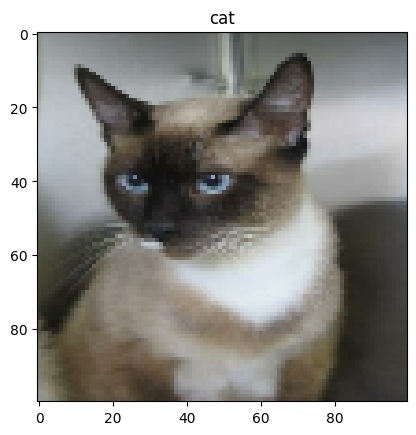

In [14]:
for images, labels in test_ds.take(1):
  predictions = model.predict(images)
  _ = plt.imshow(images[0])
  _ = plt.title(get_label_name(round(predictions[0][0])))

In [15]:
predictions = model.predict(test_ds)

73/73 [==============================] - 8s 107ms/step


In [16]:
predictions = tf.math.round(predictions)

In [17]:
labels = np.concatenate([y for x, y in test_ds], axis=0)
print(labels)

[0 1 1 ... 0 1 0]


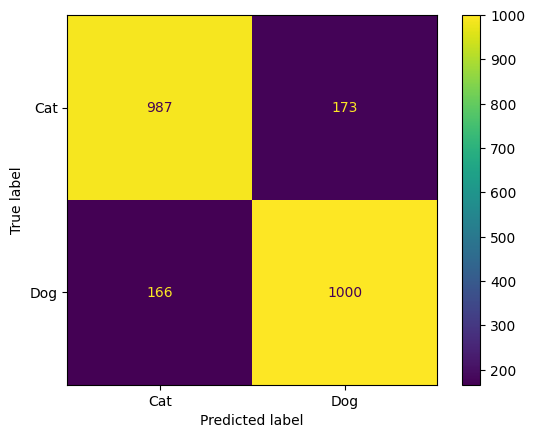

In [18]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cat", "Dog"])

cm_display.plot()
plt.show()